# Signal propagation of auto-regulatory positive feedback cells

Model of a population of auto-regulatory positive feedback gene circuit in artificial cells.

<img src='Cell Communication.png',width=800>

## Deterministic model
The rate equations for $lacI$ $(I)$, internal $AHL$ $(A_i)$, and external $AHL$ $(A_e)$ are shown below. Expression of $lacI$ follows a Hill function, with some basal expression $(\beta )$. Production of AHL is linearly dependent on the concentration of $lacI$ - this assumes that the AHL precursor is in excess. $AHL$ diffuses between internal and external compartments by the membrane diffusion coefficient $D$. The external $AHL$ diffuses in the medium according to a Laplacian operator $\Delta A_e$ with a diffusion coefficient of $AHL$ through the medium, $D_e$. Degradation of molecules are assumed to be negligible.

\begin{equation}
\frac{dI}{dt}=\beta+\frac{vI^n}{K+I^n}\\
\end{equation}
\begin{equation}
\frac{dA_i}{dt}=\alpha I-D(A_i-A_e)\\
\end{equation}
\begin{equation}
\frac{dA_e}{dt}=D(A_i-A_e)+D_e\Delta A_e\\
\end{equation}

In [1]:
#Import packages.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import ProgressBar
plt.ioff()

In [4]:
#Rate equations.
def dI(beta,v,K,n,Ic):
    return beta+(v*Aic**n)/(K+Aic**n)
def dAi(alpha,D,Aic,Aec,Ic):
    return alpha*Ic-D*(Aic-Aec)
def dAe(D,De,Aic,Aec,deltaAe):
    return D*(Aic-Aec)+deltaAe

#Laplacian operator.
def laplacian(De,Ae):
    Ae_top=Ae[0:-2,1:-1]
    Ae_left=Ae[1:-1,0:-2]
    Ae_bottom=Ae[2:,1:-1]
    Ae_right=Ae[1:-1,2:]
    Ae_center=Ae[1:-1,1:-1]
    return De*((Ae_top+Ae_left+Ae_bottom+Ae_right-4*Ae_center)/dx**2)

#Plotting function.
def plot_results(I,Ai,Ae,i):
    plt.figure(figsize=(13,3.5))
    titles=['LuxI','Internal AHL','External AHL']
    for idx,j in enumerate([I,Ai,Ae]):
        plt.subplot(1,3,idx+1)
        plt.imshow(j,cmap='Greens',interpolation='nearest',aspect='auto')
        plt.title(titles[idx],size=15)
        plt.xticks(size=13)
        plt.yticks(size=13)
        #plt.colorbar().ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()
    #plt.savefig('simulation_'+str(i)+'.png')
    return

In [5]:
#Parameters.
beta=0.05
v=0.5
K=0.5
n=1.2
alpha=0.1
D=0.1
De=10

In [6]:
#Initialize 2D array.
size=11
dx=1
I=np.zeros((size,size))
Ai=np.zeros((size,size))
Ae=np.zeros((size,size))

#Set initial conditions.
Ae[int(size/2)][int(size/2)]=0.1

#Time steps.
maxt=10
dt=0.001

100% (10000 of 10000) |###################| Elapsed Time: 0:00:00 Time: 0:00:00


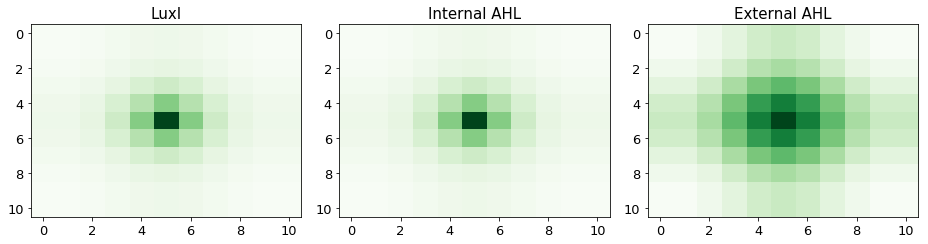

In [7]:
pbar=ProgressBar()
#Simulation using finite difference method.
for i in pbar(range(int(maxt/dt))):
    #Compute the Laplacian.
    deltaAe=laplacian(De,Ae)
    #Take values inside the grid.
    Ic,Aic,Aec=I[1:-1,1:-1],Ai[1:-1,1:-1],Ae[1:-1,1:-1]
    #Update the variables.
    I[1:-1,1:-1]=Ic+dt*dI(beta,v,K,n,Ic)
    Ai[1:-1,1:-1]=Aic+dt*dAi(alpha,D,Aic,Aec,Ic)
    Ae[1:-1,1:-1]=Aec+dt*dAe(D,De,Aic,Aec,deltaAe)
    #Neumann conditions: derivatives at the edges are null.
    for Z in (I,Ai,Ae):
        Z[0,:]=Z[1,:]
        Z[-1,:]=Z[-2,:]
        Z[:,0]=Z[:,1]
        Z[:,-1]=Z[:,-2]
#     if i%20==0 and i<500:
#         plot_results(I,Ai,Ae,i)
#         plt.close()
#Plot results.
plot_results(I,Ai,Ae,i)

## Stochastic model
With noise and stochastic gene expression, small perturbations might result in heterogeneous gene expression because of positive feedback. The elementary reactions of the system are listed below.

\begin{equation}
DNA \xrightarrow{k_1} DNA+mRNA
\end{equation}
\begin{equation}
mRNA \xrightarrow{k_2} mRNA+luxI
\end{equation}
\begin{equation}
luxI \xrightarrow{k_3} luxI+AHL_i
\end{equation}
\begin{equation}
AHL_i+DNA \xrightarrow{k_4} DNA:AHL_i
\end{equation}
\begin{equation}
DNA:AHL_i \xrightarrow{k_5} DNA:AHL_i+mRNA
\end{equation}
\begin{equation}
mRNA \xrightarrow{\delta_{mRNA}} 0
\end{equation}
\begin{equation}
AHL_i \leftrightarrow AHL_e
\end{equation}

### Bulk reaction model

In [17]:
#Propensities.
def propensity(params,states):
    props=np.array([[params[0][-1]*states[0][-1]],[params[1][-1]*states[1][-1]],
                    [params[2][-1]*states[2][-1]],[params[3][-1]*states[3][-1]*states[0][-1]],
                    [params[4][-1]*states[4][-1]],[params[5][-1]*states[1][-1]],
                    [params[6][-1]*states[3][-1]],[params[7][-1]*states[5][-1]]])
    sum_props=np.sum(props)
    return props,sum_props

#Random time step.
def tau(sum_props):
    return np.log(1/np.random.uniform(0,1))/sum_props

#Reaction step.
def reaction(props,sum_props):
    r=np.random.uniform(0,1)*np.sum(props)
    step=1
    while props[0:step].sum()<r:
        step=step+1
    return step

#Trajectory function.        
def trajectory(c,x,v,t_max):
    t=[0]
    while t[-1]<t_max:
        props,sum_props=propensity(c,x)
        t.append(t[-1]+tau(sum_props))
        v_j=np.transpose([net[reaction(props,sum_props)-1][:]])
        x=np.append(x,np.transpose([x[:,-1]])+v_j,axis=1)
    return t,x

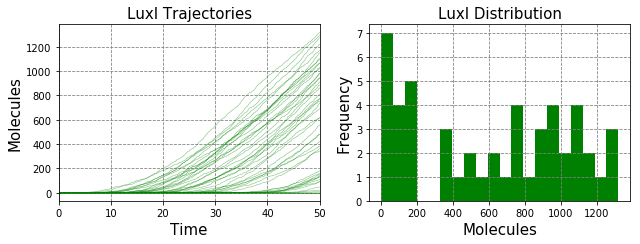

In [20]:
#Petri net.
pre=np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[1,0,0,1,0,0],
              [0,0,0,0,1,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,0,1]])
post=np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,0,1,0],
               [0,1,0,0,1,0],[0,0,0,0,0,0],[0,0,0,0,0,1],[0,0,0,1,0,0]])
net=post-pre #[DNA,mRNA,luxI,AHLi,DNA:AHLi,AHLe]

#Parameters.
params=[0.005,0.5,0.5,0.5,0.5,0.05,0.3,0.05] #[k1,k2,k3,k4,k5,dmrna,diffie,diffei]
c=np.transpose([np.array(params)])

#Run and plot simulation.
t_max=50
x_dist=[]
plt.figure(figsize=(9,3.5))
plt.subplot(1,2,1)
for i in range(0,50):
    states=[10,0,0,0,0,0] #[DNA,mRNA,luxI,AHLi,DNA:AHLi,AHLe]
    x=np.transpose([np.array(states)])
    t,x=trajectory(c,x,net,t_max)
    plt.plot(t,x[2],label='LuxI',color='green',alpha=0.5,linewidth=0.5)
    x_dist.append(x[2][-1])
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.xlabel('Time',size=15)
plt.ylabel('Molecules',size=15)
plt.title('LuxI Trajectories',size=15)
plt.xlim(0,t_max)

#Distribution of LuxI.
plt.subplot(1,2,2)
plt.hist(x_dist,bins=20,color='green')
plt.xlabel('Molecules',size=15)
plt.ylabel('Frequency',size=15)
plt.title('LuxI Distribution',size=15)
plt.grid(b=True,which='major',color='grey',linestyle='--')
plt.tight_layout()
plt.show()

### 2D reaction only model

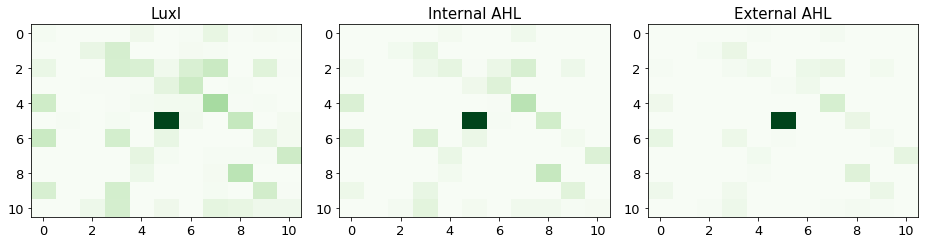

In [19]:
#Initialize 2D array.
size=11
dx=1
row=np.repeat([np.zeros(6)], size, axis=0)
matrix=np.repeat([row],size,axis=0)

#Set initial conditions.
matrix[int(size/2)][int(size/2)][3]=10
for row in matrix:
    for col in row:
        col[0]=10

#Time.
t_max=15

#Run simulation.
luxi_row=[]
ahli_row=[]
ahle_row=[]
for row in matrix:
    luxi_col=[]
    ahli_col=[]
    ahle_col=[]
    for col in row:
        x=np.transpose([col])
        t,x=trajectory(c,x,net,t_max)
        luxi_col.append(x[2][-1])
        ahli_col.append(x[3][-1])
        ahle_col.append(x[5][-1])
    luxi_row.append(luxi_col)
    ahli_row.append(ahli_col)
    ahle_row.append(ahle_col)

#Plot results.
plot_results(luxi_row,ahli_row,ahle_row,1)

### 2D reaction-diffusion model

In [21]:
#Import packages.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
#Initialize 2D array.
size=11
dx=1
row=np.repeat([np.zeros(6)], size, axis=0)
state=np.repeat([row],size,axis=0)

#Set initial conditions.
state[int(size/2)][int(size/2)][5]=100
for row in state:
    for col in row:
        col[0]=10

#Time.
max_t=10
time=[0]
#Parameters.
params=[0.001,0.5,0.5,0.05,0.5,0.05,0.3,0.3,1] #[k1,k2,k3,k4,k5,dmrna,diffie,diffei,diff]
c=np.transpose([np.array(params)])

In [23]:
def rxn_prop(params,state):
    for i,row in enumerate(state):
        for j,col in enumerate(row):
            vox_prop=np.array([[params[0][-1]*col[0]],[params[1][-1]*col[1]],
                               [params[2][-1]*col[2]],[params[3][-1]*col[3]*col[0]],
                               [params[4][-1]*col[4]],[params[5][-1]*col[1]],
                               [params[6][-1]*col[3]],[params[7][-1]*col[5]]])
            if j==0:
                col_props=np.transpose(vox_prop)
            else:
                col_props=np.append(col_props,np.transpose(vox_prop),axis=0)
        if i==0:
            row_props=np.array([col_props])
        else:
            row_props=np.vstack((row_props,np.array([col_props])))
    return row_props

In [24]:
def diff_prop(params,state):
    for i,row in enumerate(state):
        for j,col in enumerate(row):
            vox_prop=np.array([[params[8][-1]*col[5]],[params[8][-1]*col[5]],
                               [params[8][-1]*col[5]],[params[8][-1]*col[5]]])
            if j==0:
                col_props=np.transpose(vox_prop)
            else:
                col_props=np.append(col_props,np.transpose(vox_prop),axis=0)
        if i==0:
            row_props=np.array([col_props])
        else:
            row_props=np.vstack((row_props,np.array([col_props])))
    return row_props

In [25]:
def rand_times(state,rxn,diff):
    i=state.shape[0:2][0]
    j=state.shape[0:2][1]
    ti=1/(rxn.sum(axis=-1)+diff.sum(axis=-1))*np.log(1/np.random.rand(i,j))
    return ti

In [26]:
def chem_rxn(vox_prop):
    r2=vox_prop.sum()*np.random.rand()
    j_temp=1
    while vox_prop[0:j_temp].sum()<r2:
        j_temp=j_temp+1
    return j_temp

In [27]:
def directions(row,col):
    #1:right,2:left,3:up,4:down.
    direction_choice=[1,2,3,4]
    if row==0:
        direction_choice.remove(3)
    if row==state.shape[0]-1:
        direction_choice.remove(4)
    if col==0:
        direction_choice.remove(2)
    if col==state.shape[1]-1:
        direction_choice.remove(1)
    return tuple(direction_choice)

In [67]:
while time[-1]<max_t:
    #Calculate propensities.
    rxn=rxn_prop(c,state)
    diff=diff_prop(c,state)
    rxn_sum=np.sum(rxn)
    diff_sum=np.sum(diff)
    #Next time step.
    ti=rand_times(state,rxn,diff)
    row=np.where(ti==np.min(ti))[0][0]
    col=np.where(ti==np.min(ti))[1][0]
    tau=np.min(ti)
    r1=np.random.rand()
    if rxn_sum/(rxn_sum+diff_sum)>r1:
        #Chemical reaction.
        state[row][col]=state[row][col]+net[chem_rxn(rxn[row][col])-1]
        time.append(time[-1]+tau)
    elif rxn_sum/(rxn_sum+diff_sum)<=r1 and state[row][col][5]>0:
        #Diffusion event.
        state[row][col]=state[row][col]+np.array([0,0,0,0,0,-1])
        direction=np.random.choice(directions(row,col))
        if direction==1:
            state[row][col+1]=state[row][col+1]+np.array([0,0,0,0,0,1])
        elif direction==2:
            state[row][col-1]=state[row][col-1]+np.array([0,0,0,0,0,1])
        elif direction==3:
            state[row-1][col]=state[row-1][col]+np.array([0,0,0,0,0,1])
        elif direction==4:
            state[row+1][col]=state[row+1][col]+np.array([0,0,0,0,0,1])
        time.append(time[-1]+tau)

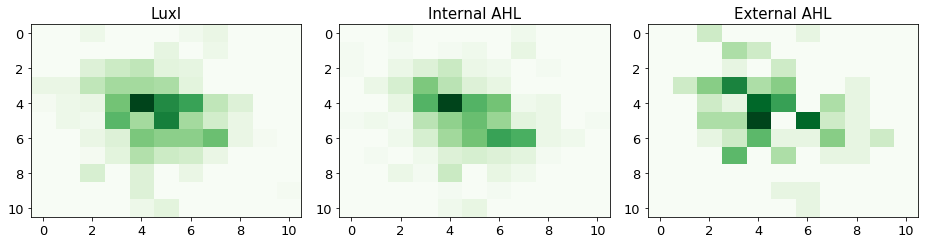

In [68]:
col=[]
for i in state:
    row=[]
    for j in i:
        row.append(j[2])
    col.append(row)
luxi=np.array(col)
col=[]
for i in state:
    row=[]
    for j in i:
        row.append(j[3])
    col.append(row)
ahli=np.array(col)
col=[]
for i in state:
    row=[]
    for j in i:
        row.append(j[5])
    col.append(row)
ahle=np.array(col)
plot_results(luxi,ahli,ahle,100)

# Script to make images for GIF

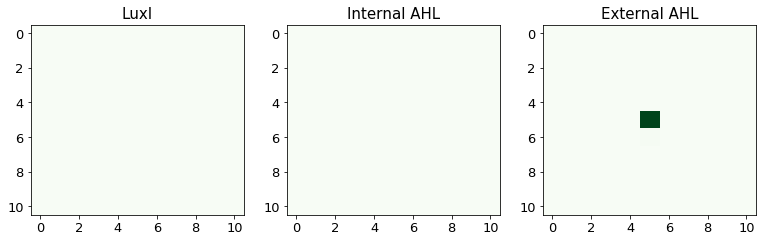

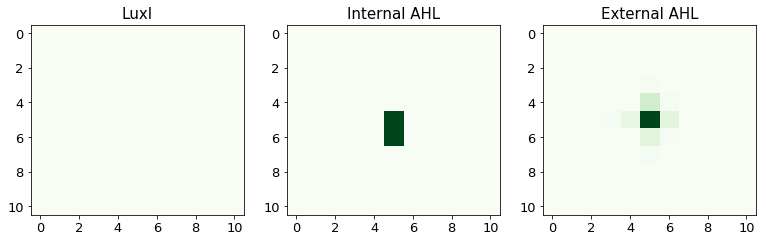

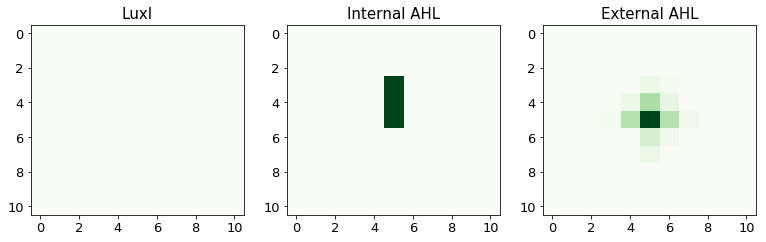

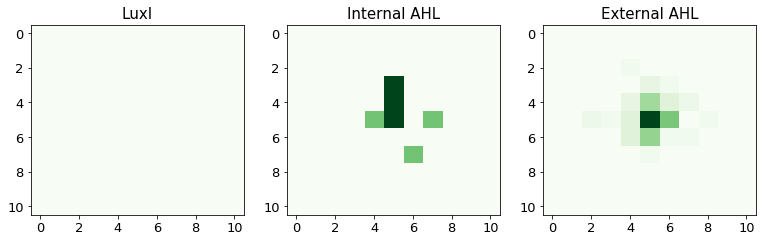

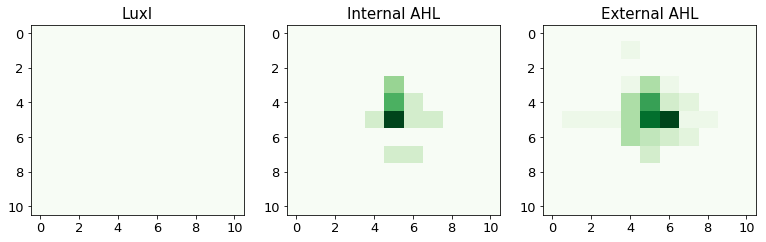

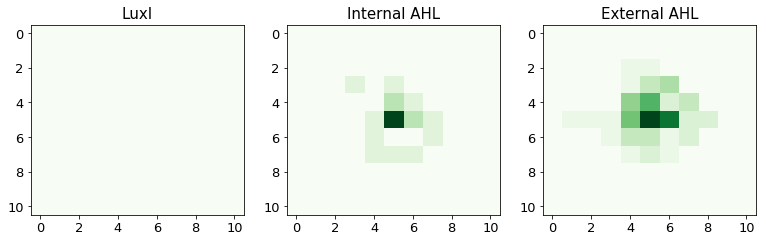

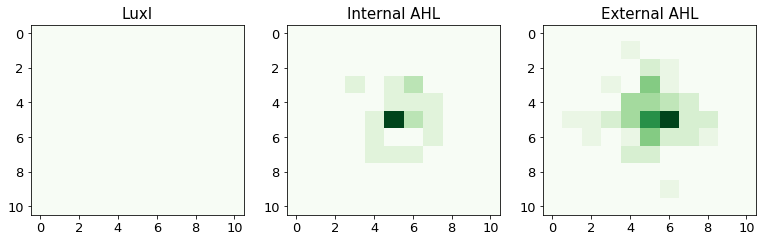

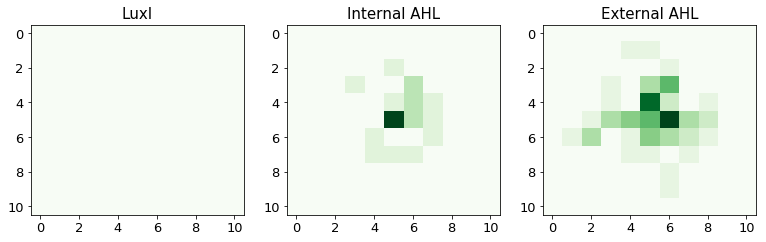

In [79]:
#Initialize 2D array.
size=11
dx=1
row=np.repeat([np.zeros(6)], size, axis=0)
state=np.repeat([row],size,axis=0)

#Set initial conditions.
state[int(size/2)][int(size/2)][5]=100
for row in state:
    for col in row:
        col[0]=10

#Time.
max_t=5
time=[0]
#Parameters.
params=[0.0005,0.5,0.5,0.05,0.5,0.05,0.3,0.3,1] #[k1,k2,k3,k4,k5,dmrna,diffie,diffei,diff]
c=np.transpose([np.array(params)])

#Plotting function.
def plot_results(I,Ai,Ae,i):
    plt.figure(figsize=(13,3.5))
    titles=['LuxI','Internal AHL','External AHL']
    for idx,j in enumerate([I,Ai,Ae]):
        plt.subplot(1,3,idx+1)
        plt.imshow(j,cmap='Greens',interpolation='nearest',aspect='auto')
        plt.title(titles[idx],size=15)
        plt.xticks(size=13)
        plt.yticks(size=13)
        #plt.colorbar().ax.tick_params(labelsize=12)
    #plt.tight_layout()
    #plt.show()
    plt.savefig('simulation_'+str(i)+'.png')
    return

w=0
while time[-1]<max_t:
    #Calculate propensities.
    rxn=rxn_prop(c,state)
    diff=diff_prop(c,state)
    rxn_sum=np.sum(rxn)
    diff_sum=np.sum(diff)
    #Next time step.
    ti=rand_times(state,rxn,diff)
    row=np.where(ti==np.min(ti))[0][0]
    col=np.where(ti==np.min(ti))[1][0]
    tau=np.min(ti)
    r1=np.random.rand()
    if rxn_sum/(rxn_sum+diff_sum)>r1:
        #Chemical reaction.
        state[row][col]=state[row][col]+net[chem_rxn(rxn[row][col])-1]
        time.append(time[-1]+tau)
    elif rxn_sum/(rxn_sum+diff_sum)<=r1 and state[row][col][5]>0:
        #Diffusion event.
        state[row][col]=state[row][col]+np.array([0,0,0,0,0,-1])
        direction=np.random.choice(directions(row,col))
        if direction==1:
            state[row][col+1]=state[row][col+1]+np.array([0,0,0,0,0,1])
        elif direction==2:
            state[row][col-1]=state[row][col-1]+np.array([0,0,0,0,0,1])
        elif direction==3:
            state[row-1][col]=state[row-1][col]+np.array([0,0,0,0,0,1])
        elif direction==4:
            state[row+1][col]=state[row+1][col]+np.array([0,0,0,0,0,1])
        time.append(time[-1]+tau)
    #Get image after every x steps.
    if w%50==0:
        col=[]
        for i in state:
            row=[]
            for j in i:
                row.append(j[2])
            col.append(row)
        luxi=np.array(col)
        col=[]
        for i in state:
            row=[]
            for j in i:
                row.append(j[3])
            col.append(row)
        ahli=np.array(col)
        col=[]
        for i in state:
            row=[]
            for j in i:
                row.append(j[5])
            col.append(row)
        ahle=np.array(col)
        plot_results(luxi,ahli,ahle,w)
    w=w+1